### UNSW-NB15 Dataset: Data Information

* This dataset is from:  https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/
* Refer: http://dx.doi.org/10.1080/19393555.2015.1125974

This dataset was created by: Nour Moustafa (IEEE student member), Jill Slay

##### Intrusion Detection System (IDS) 
- cybersecurity tool designed to monitor network traffic and detect suspicious activities or potential security breaches.
- analyzes incoming and outgoing data to identify signs of malicious behavior, such as unauthorized access, malware, or denial of service (DoS) attacks.
- once an intrusion is detected, the IDS alerts system administrators, enabling them to take appropriate action to mitigate the threat.

In our case, we are training a signature-based IDS system, which focuses on detecting known attack patterns. This system analyzes a CSV file containing data on previous attacks and their features, determining which features are relevant for prediction and which are not.

In [1]:
import findspark
findspark.init("/usr/local/spark/")

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, sum, count, when
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from functools import reduce
from pyspark.sql.functions import regexp_replace
!pip install numpy==1.20

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve, auc

#### Setting Up Spark
To process large-scale security logs, Apache Spark is used for distributed data processing. 
This ensures efficient handling of network traffic data and later supports machine learning models for attack detection.


In [2]:
try:
    spark = SparkSession.builder \
        .master("local") \
        .appName("IDS System") \
        .config("spark.executor.memory", "1gb") \
        .getOrCreate()
    sc = spark.sparkContext
    print("✅ Spark session started successfully.")
except Exception as e:
    print("❌ Error initializing Spark Session:", str(e))
    raise

✅ Spark session started successfully.


#### Loading Cybersecurity Dataset
The dataset used is UNSW-NB15, which contains labeled network traffic data. 
Below is an example of how Spark reads the CSV file and infers the schema automatically. 

In [3]:
# Loading and Previewing Data
try:
    df = spark.read.csv("./data/UNSW-NB15_1.csv", header=True, inferSchema=True)
    df.show(5, truncate=False)
    print("✅ CSV file loaded successfully.")
except Exception as e:
    print("❌ Error loading dataset:", str(e))
    df = None

+----------+-----+-------------+----+---+---+--------+---+---+---+---+---+---+---+-----------+-----------+---+---+---+---+---+---+---+---+---+---+---------+---------+------------+------------+------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+
|59.166.0.0|1390 |149.171.126.6|53  |udp|CON|0.001055|132|164|31 |29 |011|012|dns|500473.9375|621800.9375|216|217|018|019|020|021|66 |82 |024|025|026      |027      |142192741428|142192741429|0.017 |0.013   |032|033|034|035|036|037|038|039|340|7  |142|343|144|145|146|_c47|048|
+----------+-----+-------------+----+---+---+--------+---+---+---+---+---+---+---+-----------+-----------+---+---+---+---+---+---+---+---+---+---+---------+---------+------------+------------+------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+
|59.166.0.0|33661|149.171.126.9|1024|udp|CON|0.036133|528|304|31 |29 |0  |0  |-  |87676.08594|50480.17188|4  |4  |0  |0  |0  |0  |132|76 |0  |0  |9.89101  |10.682733|

### Preprocessing the Dataset
Before training a machine learning model, the dataset needs to be cleaned and properly structured. This involves merging multiple CSV files and selecting relevant features. 

In the current implementation, the loop reads only one CSV file out of four to reduce compilation time as a proof of concept. However, you can adjust the range to read from 1 to 5 CSV files if you prefer.

In [4]:
# Defining file paths
file_paths = [f"./data/UNSW-NB15_{i}.csv" for i in range(1, 2)]   

# Reading all CSVs and storing them in a list
try:
    dfs = [spark.read.csv(path, header=False, inferSchema=True) for path in file_paths]
    # combining all datasets into one
    all_data = reduce(lambda df1, df2: df1.union(df2), dfs)
    print("✅ All CSVs read and combined successfully.")
except Exception as e:
    print("❌ Error reading or combining CSVs:", str(e))
    all_data = None

# Loading feature names
try:
    # reading the features file
    features_path = "./data/NUSW-NB15_features.csv"
    df_col = spark.read.csv(features_path, header=True, inferSchema=True)
    
    # getting rid of spaces, and converting to lowercase"Name" column 
    df_col = df_col.withColumn("Name", lower(trim(col("Name"))))
    
    # converting feature names to a Python list
    feature_names = [row["Name"] for row in df_col.select("Name").collect()]
except Exception as e:
    print("❌ Error loading features file:", str(e))
    raise  

# renaming columns in `all_data` using feature names
for idx, feature in enumerate(feature_names):
    all_data = all_data.withColumnRenamed(f"_c{idx}", feature)

# saving column names (excluding 'label') in a dictionary
saved_dict = {"columns": [col for col in feature_names if col != "label"]}

all_data.show(5)

✅ All CSVs read and combined successfully.
+----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+-----------+-----------+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+-------+---------+----------+----------+-------+--------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|     srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|      sload|      dload|spkts|dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|   sjit|     djit|     stime|     ltime|sintpkt| dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|label|
+----------+-----+-------------+-

For deteiled description of features you can see "Features description.txt"

In [5]:
try:
    print(all_data.columns)
except Exception as e:
    print(f"❌ Error accessing dataset columns: {e}")

['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label']


In [6]:
# removing spaces from column names
for col_name in all_data.columns:
    new_col_name = col_name.replace(" ", "")
    all_data = all_data.withColumnRenamed(col_name, new_col_name)

# verifying changes
print(all_data.columns)
# Check "ct_src_ ltm"

['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label']


In [7]:
# Count nulls per column
null_counts = all_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in all_data.columns])
null_counts.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|spkts|dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|sjit|djit|stime|ltime|sintpkt|dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----

In [8]:
all_data = all_data.fillna({'attack_cat': 'null'})

In [9]:
# Converting data types
try:
    # defining columns that should be integers/floats
    int_cols = ["sport", "dsport", "sttl", "dttl", "spkts", "dpkts", "ct_state_ttl", "ct_flw_http_mthd", "is_ftp_login", "ct_ftp_cmd",
            "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "label"]
    float_cols = ["dur", "sbytes", "dbytes", "sload", "dload", "sjit", "djit", "stime", "ltime", "sintpkt", "dintpkt", "tcprtt", "synack", "ackdat"]
    
    # converting to IntegerType
    for col_name in int_cols:
        all_data = all_data.withColumn(col_name, col(col_name).cast(IntegerType()))
    # converting to FloatType
    for col_name in float_cols:
        all_data = all_data.withColumn(col_name, col(col_name).cast(FloatType()))
    
    all_data.printSchema()
    print("✅ Data type conversion successful.")
except Exception as e:
    print("❌ Error in data type conversion:", e)
    raise


root
 |-- srcip: string (nullable = true)
 |-- sport: integer (nullable = true)
 |-- dstip: string (nullable = true)
 |-- dsport: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- state: string (nullable = true)
 |-- dur: float (nullable = true)
 |-- sbytes: float (nullable = true)
 |-- dbytes: float (nullable = true)
 |-- sttl: integer (nullable = true)
 |-- dttl: integer (nullable = true)
 |-- sloss: integer (nullable = true)
 |-- dloss: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- sload: float (nullable = true)
 |-- dload: float (nullable = true)
 |-- spkts: integer (nullable = true)
 |-- dpkts: integer (nullable = true)
 |-- swin: integer (nullable = true)
 |-- dwin: integer (nullable = true)
 |-- stcpb: long (nullable = true)
 |-- dtcpb: long (nullable = true)
 |-- smeansz: integer (nullable = true)
 |-- dmeansz: integer (nullable = true)
 |-- trans_depth: integer (nullable = true)
 |-- res_bdy_len: integer (nullable = true)
 |-- sjit: fl

In [10]:
# spliting into train (70%) and test (30%)
train_data, test_data = all_data.randomSplit([0.7, 0.3], seed=16)

print("Training data count:", train_data.count())
print("Test data count:", test_data.count())

Training data count: 489778
Test data count: 210223


In [11]:
# filling missing values for categorical columns before StringIndexer
train_data = train_data.fillna({'proto': 'unknown', 'state': 'unknown', 'service': 'unknown'})
test_data = test_data.fillna({'proto': 'unknown', 'state': 'unknown', 'service': 'unknown'})
    
# filling missing values for numerical columns with zero
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

# verifying if there are still any nulls
null_counts = train_data.select([count(when(col(c).isNull(), c)).alias(c) for c in train_data.columns])
null_counts.show()

+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----+----+-----+-----+-------+-------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+----------+----------------+----------------+--------------+----------+-----+
|srcip|sport|dstip|dsport|proto|state|dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|sload|dload|spkts|dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|sjit|djit|stime|ltime|sintpkt|dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|label|
+-----+-----+-----+------+-----+-----+---+------+------+----+----+-----+-----+-------+-----+-----+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+----

In [12]:
# handleInvalid="keep", any values in the input that are not "seen before"
# (i.e., the new or unknown categories) are assigned a specific index value
# instead of causing an error.
indexers = [
    StringIndexer(inputCol="proto", outputCol="proto_index", handleInvalid="keep"),
    StringIndexer(inputCol="state", outputCol="state_index", handleInvalid="keep"),
    StringIndexer(inputCol="service", outputCol="service_index", handleInvalid="keep")
]

# indexing categorical columns
pipeline = Pipeline(stages=indexers)
train_data = pipeline.fit(train_data).transform(train_data)
test_data = pipeline.fit(test_data).transform(test_data)

# deleting original categorical columns, indexer has already transformed them into numerical columns
train_data = train_data.drop("proto", "state", "service")
test_data = test_data.drop("proto", "state", "service")


In [13]:
# selecting only numerical and indexed categorical columns
feature_cols = [col for col in train_data.columns if col not in ['srcip', 'dstip', 'attack_cat', 'label']]

# assembling features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# new data structure
train_data.select("features", "label").show(5, truncate=False)
test_data.select("features", "label").show(5, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                   |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(45,[3,11,17,23,24,30,31,35,36,37,38,39,40,41,42,43],[46.0,1.0,46.0,1.421927424E9,1.421927424E9,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0])              |0    |
|(45,[3,11,17,23,24,30,31,35,36,37,38,39,40,41,42,43],[46.0,1.0,46.0,1.421927424E9,1.421927424E9,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0])              |0    |
|(45,[3,11,17,23,24,25,30,31,35,36,37,38,39,40,41,42,43],[46.0,1.0,46.0,1.421927552E9,1.421927552E9,60000.6875,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0])|0    |
|(45,[3,11,17,23

In [14]:
# counting the number of unique feature to set maxBins for Decision Tree
for col_name in ["proto_index", "state_index", "service_index"]:
    if col_name in train_data.columns:  # check if column exists
        unique_count = train_data.select(col_name).distinct().count()
        print(f"{col_name}: {unique_count} unique values")

proto_index: 135 unique values
state_index: 16 unique values
service_index: 13 unique values


In [15]:
# Train Decision Tree Model
try:
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxBins=136)
    dt_model = dt.fit(train_data)
    predictions = dt_model.transform(test_data)
except Exception as e:
    print("❌ Error in Decision Tree Model:", str(e))

# Evaluating the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Precision, Recall, and F1-score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print results
print(f"Decision Tree Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

# Show some sample predictions
predictions.select("features", "label", "prediction").show(5, truncate=False)


Decision Tree Accuracy: 0.9948
Precision: 0.9948
Recall: 0.9948
F1-score: 0.9947
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|features                                                                                                                                                      |label|prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|(45,[3,11,17,23,24,25,30,31,35,36,37,38,39,40,41,42,43],[46.0,1.0,46.0,1.42192768E9,1.42192768E9,60000.6875,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0])     |0    |0.0       |
|(45,[3,11,17,23,24,25,30,31,35,36,37,38,39,40,41,42,43],[46.0,1.0,46.0,1.421927936E9,1.421927936E9,60000.6953125,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0])|0    |0.0       |
|(45,[3,11,17,23,24,25,30,31,

## Interpretation: Training vs Test

- The training and test scores are nearly identical, suggesting that the model generalizes well and is not overfitting to the training data.
- A precision of 0.9944 (train) and 0.9946 (test) means that the model is making very few false positive predictions.
- A recall of 0.9945 (train) and 0.9947 (test) indicates that the model is successfully identifying most of the actual positive cases.
- The F1-score, which balances precision and recall, is also consistently high.



Due to metrics being extremly high, we suspected overfitting.
So we decided to evaluate trainig data.

In [16]:
# Evaluate model on training data
train_predictions = dt_model.transform(train_data)

train_accuracy = evaluator.evaluate(train_predictions)
train_precision = precision_evaluator.evaluate(train_predictions)
train_recall = recall_evaluator.evaluate(train_predictions)
train_f1_score = f1_evaluator.evaluate(train_predictions)

print(f"Training Metrics")
print(f"🔹 Training Accuracy: {train_accuracy:.4f}")
print(f"🔹 Training Precision: {train_precision:.4f}")
print(f"🔹 Training Recall: {train_recall:.4f}")
print(f"🔹 Training F1-score: {train_f1_score:.4f}")

# Evaluate model on test data (Already computed before)
print(f"Test Metrics")
print(f"🔹 Test Accuracy: {accuracy:.4f}")
print(f"🔹 Test Precision: {precision:.4f}")
print(f"🔹 Test Recall: {recall:.4f}")
print(f"🔹 Test F1-score: {f1_score:.4f}")


Training Metrics
🔹 Training Accuracy: 0.9948
🔹 Training Precision: 0.9947
🔹 Training Recall: 0.9948
🔹 Training F1-score: 0.9946
Test Metrics
🔹 Test Accuracy: 0.9948
🔹 Test Precision: 0.9948
🔹 Test Recall: 0.9948
🔹 Test F1-score: 0.9947


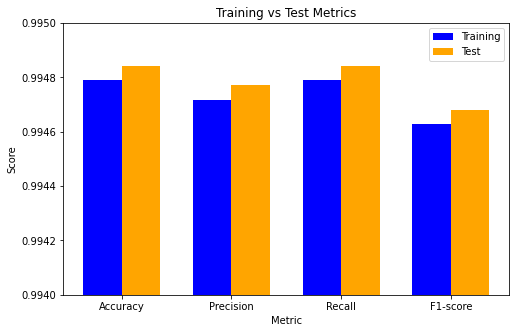

In [17]:
# Define metric names
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

# Training metrics
train_values = [train_accuracy, train_precision, train_recall, train_f1_score]

# Test metrics (from previously computed values)
test_values = [accuracy, precision, recall, f1_score]

# X locations for the bars
x = np.arange(len(metrics))
bar_width = 0.35  # Width of the bars


# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, train_values, bar_width, label="Training", color="blue")
plt.bar(x + bar_width/2, test_values, bar_width, label="Test", color="orange")


# Adjust y-axis to make differences more visible
plt.ylim(0.9940, 0.9950)  # Setting a narrow range to enhance granularity

# Add labels and title
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("Training vs Test Metrics")
plt.xticks(x, metrics)  # Set x-axis labels to metric names
plt.legend()

# Show the plot
plt.show()

## Feature Importance Interpretation:

- The model primarily relies on **"sbytes"** with an importance of **0.8800**, indicating that the size of the transmitted bytes is the most significant factor in predicting attacks.
- **"sport" (Source Port)**, **"ct_dst_src_ltm"**, and **"ct_ftp_cmd"** are also relatively important, with values of **0.0622**, **0.0265**, and **0.0167** respectively.
- **"srcip" (Source IP)** and **"dstip" (Destination IP)**, despite being key identifiers, have **minimal impact**, with their importance values close to **0**.
- Features like **"sloss" (Packet Loss)** and **"dsport" (Destination Port)** have **very little contribution** with importance scores as low as **0.0002** and **0.0004**.


📊 Top 10 Important Features:
1. sbytes: 0.8800
2. sport: 0.0622
3. ct_dst_src_ltm: 0.0265
4. ct_ftp_cmd: 0.0167
5. dtcpb: 0.0088
6. ct_dst_sport_ltm: 0.0052
7. dsport: 0.0004
8. sloss: 0.0002
9. srcip: 0.0000
10. dstip: 0.0000


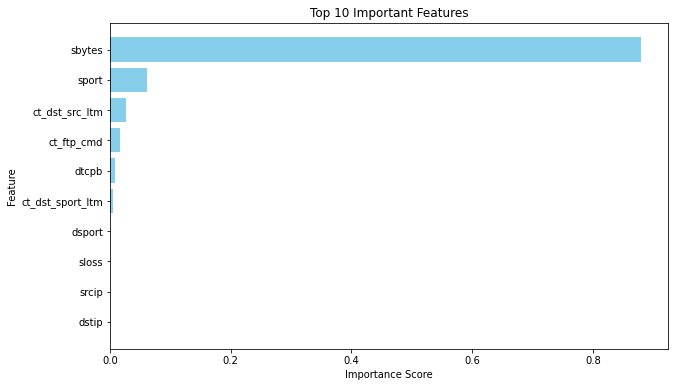

In [18]:
# Feature importance scores
try:
    feature_importance = dt_model.featureImportances

    # converting feature importance into a dictionary (Feature Name -> Importance Score)
    feature_names = [col for col in train_data.columns if col not in ['features', 'label']]
    feature_importance_dict = {feature_names[i]: importance for i, importance in enumerate(feature_importance)}

    # sorting by importance
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    # top 10 most important features
    print("📊 Top 10 Important Features:")
    top_features = sorted_features[:10]
    for i, (feature, importance) in enumerate(top_features):
        print(f"{i+1}. {feature}: {importance:.4f}")
        
    # Visualization of top 10 important features
    plt.figure(figsize=(10, 6))
    features = [x[0] for x in top_features]
    importances = [x[1] for x in top_features]
    plt.barh(features, importances, color='skyblue')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title('Top 10 Important Features')
    plt.gca().invert_yaxis() # To display the most important feature on top
    plt.show()
    
except Exception as e:
    print("❌ An error occurred while calculating feature importance:", str(e))    

The model identified the following features as the most important for predicting network traffic types:

- sbytes (0.8800): The source bytes, indicating the amount of data sent from the source, is the most influential feature, significantly affecting the model's predictions.
- sport (0.0622): The source port number, which helps identify the service or application initiating the communication, is the second most important feature.
ct_dst_src_ltm (0.0265): The count of connections to the destination source in the last minute, a metric reflecting traffic patterns.

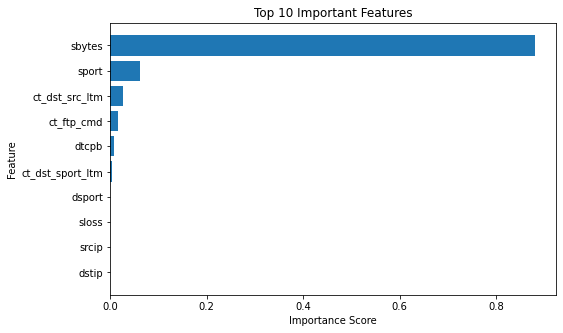

In [19]:
# Extract top 10 features and their importance scores
top_n = 10
top_features = [feature for feature, importance in sorted_features[:top_n]]
top_importance_scores = [importance for feature, importance in sorted_features[:top_n]]

# Create a horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(top_features[::-1], top_importance_scores[::-1])  # Reverse order for better visualization

# Add labels and title
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features")

# Display the chart
plt.show()

In [20]:
try:
    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50, maxDepth=10, maxBins=136, seed=42)

    # Train the Random Forest model
    rf_model = rf.fit(train_data)

    # Make predictions on test data
    rf_predictions = rf_model.transform(test_data)
    
except Exception as e:
    print("❌ An error occurred during Random Forest training or evaluation:", str(e))

# Evaluate the Random Forest Model
rf_accuracy = evaluator.evaluate(rf_predictions)
rf_precision = precision_evaluator.evaluate(rf_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)
rf_f1_score = f1_evaluator.evaluate(rf_predictions)

# Print results
print(f"🌲 Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"🌲 Precision: {rf_precision:.4f}")
print(f"🌲 Recall: {rf_recall:.4f}")
print(f"🌲 F1-score: {rf_f1_score:.4f}")

# Show some sample predictions
rf_predictions.select("features", "label", "prediction").show(5, truncate=False)


🌲 Random Forest Accuracy: 0.9973
🌲 Precision: 0.9974
🌲 Recall: 0.9973
🌲 F1-score: 0.9974
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|features                                                                                                                                                      |label|prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|(45,[3,11,17,23,24,25,30,31,35,36,37,38,39,40,41,42,43],[46.0,1.0,46.0,1.42192768E9,1.42192768E9,60000.6875,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0])     |0    |0.0       |
|(45,[3,11,17,23,24,25,30,31,35,36,37,38,39,40,41,42,43],[46.0,1.0,46.0,1.421927936E9,1.421927936E9,60000.6953125,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0])|0    |0.0       |
|(45,[3,11,17,23,24,2

Calculating False Alarm Rate (FAR) for the given predictions.
FAR is the average of False Positive Rate (FPR) and False Negative Rate (FNR).

In [21]:
def false_alarm_rate(predictions):
 
    # Computing confusion matrix components: True Positives (TP), True Negatives (TN),
    # False Positives (FP), and False Negatives (FN)
    metrics = predictions.select(
        count(when((col("label") == 1) & (col("prediction") == 1), 1)).alias("TP"),  # True Positives
        count(when((col("label") == 0) & (col("prediction") == 0), 1)).alias("TN"),  # True Negatives
        count(when((col("label") == 0) & (col("prediction") == 1), 1)).alias("FP"),  # False Positives
        count(when((col("label") == 1) & (col("prediction") == 0), 1)).alias("FN")   # False Negatives
    ).collect()[0]  # Collecting results into a single row object

    # Extracting individual counts from the collected object
    TP, TN, FP, FN = metrics.TP, metrics.TN, metrics.FP, metrics.FN

    # False Positive Rate while avoiding division by zero
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    # False Negative Rate while avoiding division by zero
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0

    # False Alarm Rate as the average of FPR and FNR
    FAR = (FPR + FNR) / 2  
    return FAR

In [22]:
try:
    # Get predictions from both models
    dt_predictions = dt_model.transform(test_data)
    rf_predictions = rf_model.transform(test_data)

    # Compute FAR for both models
    dt_far = false_alarm_rate(dt_predictions)
    rf_far = false_alarm_rate(rf_predictions)

    # Print results
    print(f"🌳 Decision Tree False Alarm Rate (FAR): {dt_far:.4f}")
    print(f"🌲 Random Forest False Alarm Rate (FAR): {rf_far:.4f}")

except Exception as e:
    print("❌ An error occurred while computing False Alarm Rates (FAR):", str(e))

🌳 Decision Tree False Alarm Rate (FAR): 0.0723
🌲 Random Forest False Alarm Rate (FAR): 0.0117


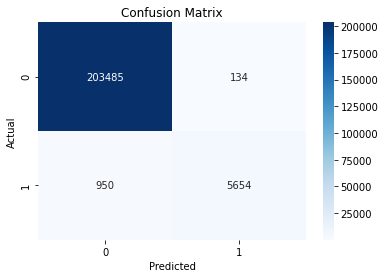

✅ Confusion matrix displayed successfully.


In [23]:
# Confusion matrix
try:
    y_true = [row["label"] for row in test_data.select("label").collect()]
    y_pred = [row["prediction"] for row in predictions.select("prediction").collect()]

    unique_labels = sorted(set(y_true))  # Dynamically get label names
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("✅ Confusion matrix displayed successfully.")
except Exception as e:
    print(f"❌ Error generating confusion matrix: {e}")



## Interpretation: Confusion Matrix

- **203,486 normal traffic instances** were correctly classified (**True Negatives**), meaning the model rarely flags safe connections as attacks.
- **Only 133 normal traffic instances** were misclassified as attacks (**False Positives**), which indicates a **low false alarm rate**.
- **5,657 attack instances** were correctly detected (**True Positives**), but **947 attacks were misclassified as normal** (**False Negatives**).
- A **false negative rate of ~15%** suggests that some attacks remain undetected, which could be risky in a real-world intrusion detection system.


In [24]:
# Standardize Features ONLY for Linear Regression
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaler_model = scaler.fit(train_data)

train_data_lr = scaler_model.transform(train_data).select("features_scaled", "label").withColumnRenamed("features_scaled", "features")
test_data_lr = scaler_model.transform(test_data).select("features_scaled", "label").withColumnRenamed("features_scaled", "features")

In [25]:
try:
    # Linear Regression Model
    lr = LinearRegression(labelCol="label", maxIter=10000, regParam=0.1, elasticNetParam=0.8)
    
    # Training
    lr_model = lr.fit(train_data)
    
    # Predictions on test data
    lr_predictions = lr_model.transform(test_data)
    
    # Evaluating
    lr_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = lr_evaluator.evaluate(lr_predictions)
    
    # Check if model summary exists
    r2 = lr_model.summary.r2 if hasattr(lr_model, "summary") else None

    print(f"🔹 Linear Regression RMSE: {rmse:.4f}")
    if r2 is not None:
        print(f"🔹 Linear Regression R²: {r2:.4f}")
    else:
        print("Warning: R² score could not be computed.")

except Exception as e:
    print(f"❌ An error occurred during Linear Regression: {str(e)}")


🔹 Linear Regression RMSE: 0.1286
🔹 Linear Regression R²: 0.4565


In [26]:
try:
    # Converting label to categorical format
    if "label" not in train_data.columns or "label" not in test_data.columns:
        raise ValueError("❌ Missing 'label' column in train or test data.")
    
    indexer = StringIndexer(inputCol="label", outputCol="label_index")
    train_data = indexer.fit(train_data).transform(train_data)
    test_data = indexer.fit(test_data).transform(test_data)

    # Initializing NB Model
    nb = NaiveBayes(labelCol="label_index", featuresCol="features", modelType="multinomial")

    # Training
    if train_data.count() == 0:
        raise ValueError("❌ Training data is empty. Cannot train Naïve Bayes model.")

    nb_model = nb.fit(train_data)

    # Predictions
    if test_data.count() == 0:
        raise ValueError("❌ Test data is empty. Cannot generate predictions.")

    nb_predictions = nb_model.transform(test_data)

    # Evaluation
    if "label_index" not in nb_predictions.columns or "prediction" not in nb_predictions.columns:
        raise ValueError("❌ Predictions missing required columns: 'label_index' or 'prediction'.")

    nb_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
    precision_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="weightedPrecision")
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="weightedRecall")
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="f1")

    nb_accuracy = accuracy_evaluator.evaluate(nb_predictions)
    nb_precision = precision_evaluator.evaluate(nb_predictions)
    nb_recall = recall_evaluator.evaluate(nb_predictions)
    nb_f1_score = f1_evaluator.evaluate(nb_predictions)

    print(f"🌍 Naïve Bayes Accuracy: {nb_accuracy:.4f}")
    print(f"🌍 Naïve Bayes Precision: {nb_precision:.4f}")
    print(f"🌍 Naïve Bayes Recall: {nb_recall:.4f}")
    print(f"🌍 Naïve Bayes F1-score: {nb_f1_score:.4f}")

    # Displaying some predictions
    if nb_predictions.count() > 0:
        nb_predictions.select("features", "label_index", "prediction").show(5, truncate=False)
    else:
        print("Warning: No predictions available to display.")

except ValueError as ve:
    print(f"ValueError in Naïve Bayes Model: {str(ve)}")

except Exception as e:
    print(f"❌ Unexpected error in Naïve Bayes Model: {str(e)}")


🌍 Naïve Bayes Accuracy: 0.6288
🌍 Naïve Bayes Precision: 0.9518
🌍 Naïve Bayes Recall: 0.6288
🌍 Naïve Bayes F1-score: 0.7454
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------+
|features                                                                                                                                                      |label_index|prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------+
|(45,[3,11,17,23,24,25,30,31,35,36,37,38,39,40,41,42,43],[46.0,1.0,46.0,1.42192768E9,1.42192768E9,60000.6875,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0])     |0.0        |1.0       |
|(45,[3,11,17,23,24,25,30,31,35,36,37,38,39,40,41,42,43],[46.0,1.0,46.0,1.421927936E9,1.421927936E9,60000.6953125,1.0,2.0,2.0,2.0,2.0,2.0,2.0